In [1]:
from glob import glob
import pandas as pd
import os
from tqdm import tqdm as tqdm 
from IPython.display import Image
from pathlib import Path
import imageio
import moviepy.video.io.ImageSequenceClip
from tqdm import tqdm
import h5py
import math
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
import json
import scipy.stats
import time
from types import SimpleNamespace
import random
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
subject_mapping = {"m00183": "sub_1",
                   "m00184": "sub_2",
                   "m00185": "sub_3",
                   "m00187": "sub_4",
                   "m00188": "sub_5",
                   "m00191": "sub_6",
                   "m00192": "sub_7",
                   "m00193": "sub_8",
                   "m00194": "sub_9",
                   "m00195": "sub_10",
                  }

In [3]:
task_name_mapping = {
        'onset': 'Sentence Onset',
        'speech': 'Speech',
        'volume': 'Volume', 
        'pitch': 'Pitch',
        'speaker': 'Speaker Identity',
        'delta_volume': 'Delta Volume',
        'delta_pitch': 'Delta Pitch',
        'gpt2_surprisal': 'GPT-2 Surprisal',
        'word_length': 'Word Length',
        'word_gap': 'Inter-word Gap',
        'word_index': 'Word Position',
        'word_head_pos': 'Head Word Position',
        'word_part_speech': 'Part of Speech',
        'frame_brightness': 'Frame Brightness',
        'global_flow': 'Global Optical Flow',
        'local_flow': 'Local Optical Flow',
        'global_flow_angle': 'Global Flow Angle',
        'local_flow_angle': 'Local Flow Angle',
        'face_num': 'Number of Faces',
    }

In [4]:
task_order =  ['onset', 'speech', 'volume', 'pitch', 'speaker', 'delta_volume', 'delta_pitch', 'gpt2_surprisal', 'word_length', 'word_gap', 'word_index', 'word_head_pos', 'word_part_speech', 'frame_brightness', 'global_flow', 'local_flow', 'global_flow_angle', 'local_flow_angle', 'face_num']

# Load results

In [5]:
# results_root = "/storage/czw/linear_voltage_single_electrode_SS_SM_prototype/linear_voltage_single_electrode"
results_root = "/storage/czw/btbench/single_electrode_btbench_full/eval_results_full_SS_SM/linear_voltage_single_electrode"


In [6]:
def get_test_results(results, eval_name):
    eval_results = results["evaluation_results"]
    assert len(eval_results.keys()) == 1
    records = []
    for subject_trial in eval_results:
        subject = subject_trial.split("_")[0][len("btbank"):]
        trial = subject_trial.split("_")[1]
        subject_trial_results = eval_results[subject_trial]['electrode']
        for electrode in subject_trial_results:
            electrode_results = subject_trial_results[electrode]
            time_bin_results = electrode_results["time_bins"]
            for time_bin in time_bin_results:
                time_bin_start = time_bin['time_bin_start']
                fold_results = time_bin['folds']
                avg_test = np.mean([f['test_roc_auc'] for f in fold_results])
                records.append({
                    "subject": subject,
                    "trial": trial,
                    "ID": f'{electrode}-sub_{subject}',
                    "electrode": electrode,
                    "avg_test": avg_test,
                    "time_bin": time_bin_start,
                    "task": eval_name
                })
        return records

In [7]:
all_records = []
all_results_paths = glob(os.path.join(results_root, "*"))
for path in tqdm(all_results_paths):
    name = Path(path).stem
    sub_id = name.split("_")[1][len("btbank"):]
    trial_id = name.split("_")[2]
    eval_name = "_".join(name.split("_")[3:])
    with open(path, "r") as f:
        results = json.load(f)
        test_results = get_test_results(results, eval_name)
    all_records += test_results
results_df = pd.DataFrame.from_records(all_records)

100%|██████████████████████████████████████████████████████████████████████████████████| 494/494 [00:26<00:00, 18.76it/s]


# Plot brains

In [8]:
matlab_xlim = (-108.0278, 108.0278)
matlab_ylim = (-72.9774, 72.9774)

save_dir = 'brain_plotting/'
base_path = 'brain_plotting/'
left_hem_file_name = 'left_hem_clean.png'
right_hem_file_name = 'right_hem_clean.png'
coords_file_name = 'elec_coords_full.csv'
correlations_file = 'lag_correlation.json'

left_hem_img = plt.imread(os.path.join(base_path, left_hem_file_name))
right_hem_img = plt.imread(os.path.join(base_path, right_hem_file_name))
coords_df = pd.read_csv(os.path.join(base_path, coords_file_name))
split_elec_id = coords_df['ID'].str.split('-')
coords_df['Subject'] = [subject_mapping[t[0]] for t in split_elec_id]
coords_df['Electrode'] = [t[1] for t in split_elec_id]

# # Scale Matlab electrode locations to Python format
def scale(x, s, d):
    return -(x - d) * s

x_scale = left_hem_img.shape[1] / (matlab_xlim[1] - matlab_xlim[0])
y_scale_l = left_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

y_scale_r = right_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

scaled_coords_df = coords_df.copy()

# scale left hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'X'].apply(lambda x: scale(x, x_scale, matlab_xlim[1]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'Y'].apply(lambda x: scale(x, y_scale_l, matlab_ylim[1]))

# scale right hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'X'].apply(lambda x: -scale(x, y_scale_r, matlab_xlim[0]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'Y'].apply(lambda x: scale(x, y_scale_r, matlab_ylim[1]))

# scaled_coords_df[]
scaled_coords_df["ID"] = scaled_coords_df.Electrode + "-" + scaled_coords_df.Subject

In [214]:
spatial_avg_results_df = results_df.groupby(['task','ID']).max(['avg_test'])

In [479]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colorbar import ColorbarBase

# grey_to_red = LinearSegmentedColormap.from_list('grey_to_red', [(0.0, 'grey'), (0.4, 'grey'), (1.0, 'red')])
grey_to_red = LinearSegmentedColormap.from_list('grey_to_red', [(0.0, 'grey'), (0.3, 'grey'), (0.4, 'yellow'), (1.0, 'red')])
# grey_to_red = LinearSegmentedColormap.from_list('grey_to_red', [(0.0, 'grey'), (1.0, 'red')])

In [480]:
import seaborn as sns
def plot_electrodes(plot_df, ax=None, hemisphere="left", title=None):
    plot_df = plot_df.dropna() #TODO NOTE
    plot_df = plot_df.sort_values(by='avg_test', ascending=True)

    ax.set_aspect('equal')

    if hemisphere=="left":
        ax.imshow(left_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==1]
    elif hemisphere=="right":
        ax.imshow(right_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==0]


    ax.axis('off')
    assert hemisphere in ["left", "right"]


    plot_title = f'{hemisphere} hemisphere'

    if title:
        plot_title += f' {title}'

    all_x = plot_df['X']
    all_y = plot_df['Y']
    color = plot_df['avg_test']

    lower = 0.49
    epsilon = 1e-4
    scale = lambda x: (np.log(max((x - lower), epsilon)))
    assert(list(sorted(color))==list(color))
    sc = ax.scatter(all_x, all_y,
                s=50,
                linewidths=1,
                c=color,
                edgecolors="black",
                clip_on=False,
                # cmap="viridis",
                cmap=grey_to_red,
                vmin=scale(0.50),
                vmax=scale(0.86),
                   )
    return sc

In [487]:
lower = 0.48
inverse_scale = lambda x: np.exp(x) + lower

In [488]:
outer[num_rows*num_cols - 1]

GridSpec(4, 5)[3:4, 4:5]

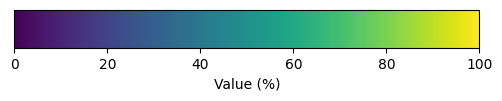

In [584]:
import matplotlib.colors as mcolors
# Create a figure and axis for the colorbar
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# Create a colormap and normalization
cmap = plt.cm.viridis  # You can choose any colormap
norm = mcolors.Normalize(vmin=0, vmax=100)  # Colorbar from 0 to 100

# Create a ScalarMappable and initialize a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for compatibility with the colorbar

# Add colorbar to the figure
cbar = fig.colorbar(sm, cax=ax, orientation='horizontal')
cbar.set_label('Value (%)')

plt.show()

/tmp/ipykernel_2105105/483245662.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


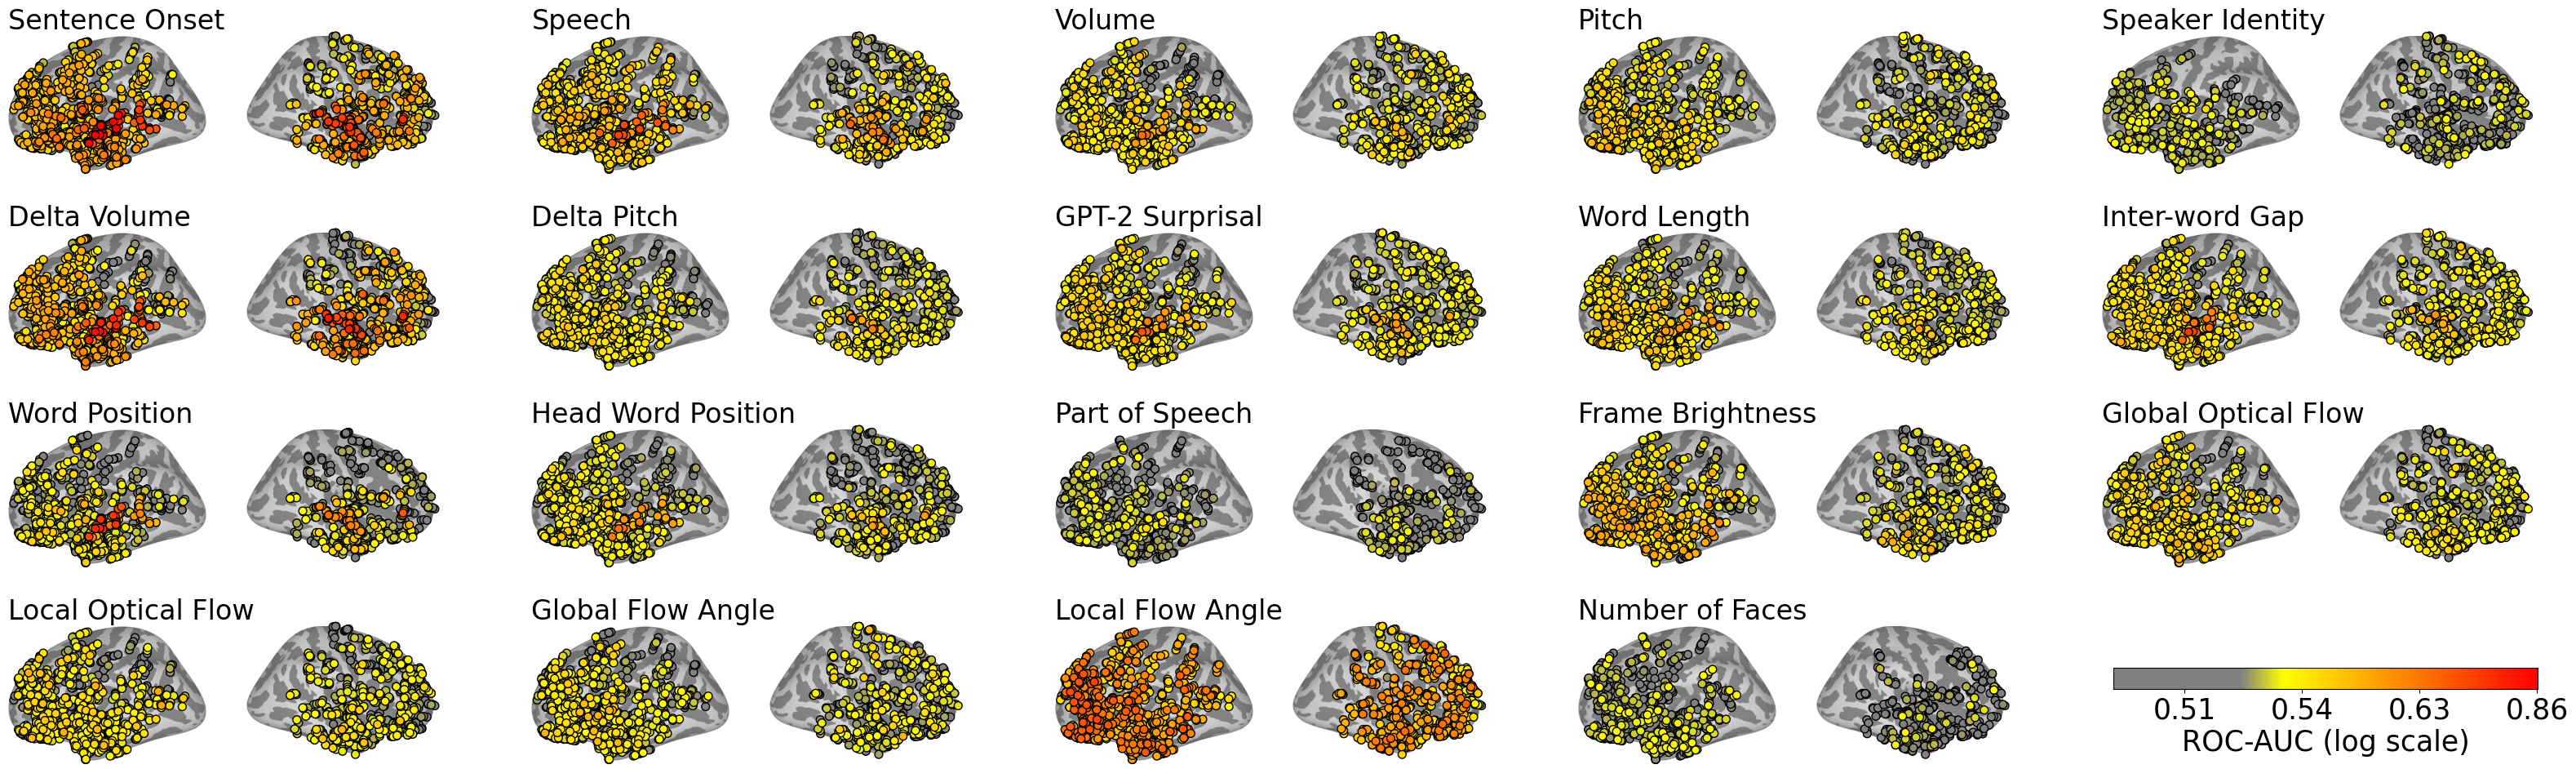

In [602]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
from matplotlib.colorbar import ColorbarBase

fig = plt.figure(figsize=(40, 12))

num_cols = 5
num_rows = 4

# num_cols = 2
# num_rows = 1

outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.2)

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(num_cols):
        # Index in outer grid
        outer_idx = i * num_cols + j

        # if i*num_cols+j >= num_rows*num_cols - 1:
        if i*num_cols+j >= 19:
            ax = fig.add_subplot(outer[num_rows*num_cols - 1])
            cbar = fig.colorbar(sc, ax=ax, orientation='horizontal')
            cbar.ax.set_position([0.77,0.12,0.13,0.1])  # or use cbar.ax.set_position([...]) for fine-tuning
            cbar.ax.tick_params(labelsize=25)
            cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{inverse_scale(val):.02}"))
            cbar.set_label("ROC-AUC (log scale)", fontsize=25)
            ax.set_axis_off()
            continue
            
        # Define inner 2x1 grid within this cell
        inner = gridspec.GridSpecFromSubplotSpec(
            1, 2, subplot_spec=outer[outer_idx], hspace=0.1
        )
            
        for k in range(2):
            ax = fig.add_subplot(inner[k])
#             print(i*4+j)
            task = task_order[i*num_cols+j]
            # task = "local_flow_angle"
            task_df = spatial_avg_results_df.loc[task].copy()
            scale = lambda x: (np.log(max((x - lower), epsilon)))
            lower = 0.49
            epsilon = 1e-4
            task_df.loc[:,'avg_test'] = task_df['avg_test'].apply(scale)

            # task_df.loc[:,'avg_test'] = np.log(100*task_df['avg_test'])
            merged_df = pd.merge(scaled_coords_df, task_df, on="ID", how="left")
            hem = ["left","right"][k]
            sc = plot_electrodes(merged_df, hemisphere=hem, ax=ax, title=task)
#             ax.set_title(task)
            
            if k == 0:
                ax.set_title(task_name_mapping[task], fontsize=24, loc='left')
        # break
    # break
                
plt.tight_layout()

In [600]:
results_df[results_df.task=='local_flow_angle'].groupby("ID").max('avg_test')

,avg_test,time_bin
ID,,
F10Fa1-sub_10,0.598942,1.125
F10Fa10-sub_10,0.601362,1.125
F10Fa11-sub_10,0.578779,1.125
F10Fa12-sub_10,0.556270,1.125
F10Fa14-sub_10,0.603044,1.125
...,...,...
T3bOT4-sub_1,0.552300,1.125
T3bOT5-sub_1,0.559145,1.125
T3bOT6-sub_1,0.549321,1.125


In [591]:
task_df

,avg_test,time_bin
ID,,
F10Fa1-sub_10,0.598942,1.125
F10Fa10-sub_10,0.601362,1.125
F10Fa11-sub_10,0.578779,1.125
F10Fa12-sub_10,0.556270,1.125
F10Fa14-sub_10,0.603044,1.125
...,...,...
T3bOT4-sub_1,0.552300,1.125
T3bOT5-sub_1,0.559145,1.125
T3bOT6-sub_1,0.549321,1.125


In [492]:
task_df.max()

avg_test    0.544684
time_bin    1.125000
dtype: float64

# Make time series 

In [493]:
global_min = 1
global_max = 0

for task in task_order:
    # print(task
    task_df = results_df[results_df.task==task].groupby("ID").mean(["avg_test"])
#         good_elecs = task_df[task_df.avg_test>0.5].index   
    
    good_elecs = results_df[results_df.task==task].groupby("ID").mean(["avg_test"]).sort_values(by="avg_test").dropna()[-100:].index  
    time_df = results_df[(results_df.task==task) & (results_df.ID.isin(good_elecs))].dropna()
    global_min = min(np.percentile(time_df['avg_test'], 5), global_min)
    print(global_min)
    global_max = max(np.percentile(time_df['avg_test'], 95), global_max)

0.4915094482846998
0.4915094482846998
0.4848066227844811
0.48382510547222773
0.48382510547222773
0.48382510547222773
0.48382510547222773
0.48382510547222773
0.48382510547222773
0.48382510547222773
0.48382510547222773
0.48382510547222773
0.48382510547222773
0.476889094771197
0.476889094771197
0.476889094771197
0.476889094771197
0.4574230681021226
0.4574230681021226


In [494]:
np.percentile(time_df['avg_test'],5)

np.float64(0.48958968450778373)

In [495]:
global_min, global_max

(np.float64(0.4574230681021226), np.float64(0.6880831948320855))

In [496]:
scale(0.6)

np.float64(-2.207274913189721)

/tmp/ipykernel_2105105/3690555369.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


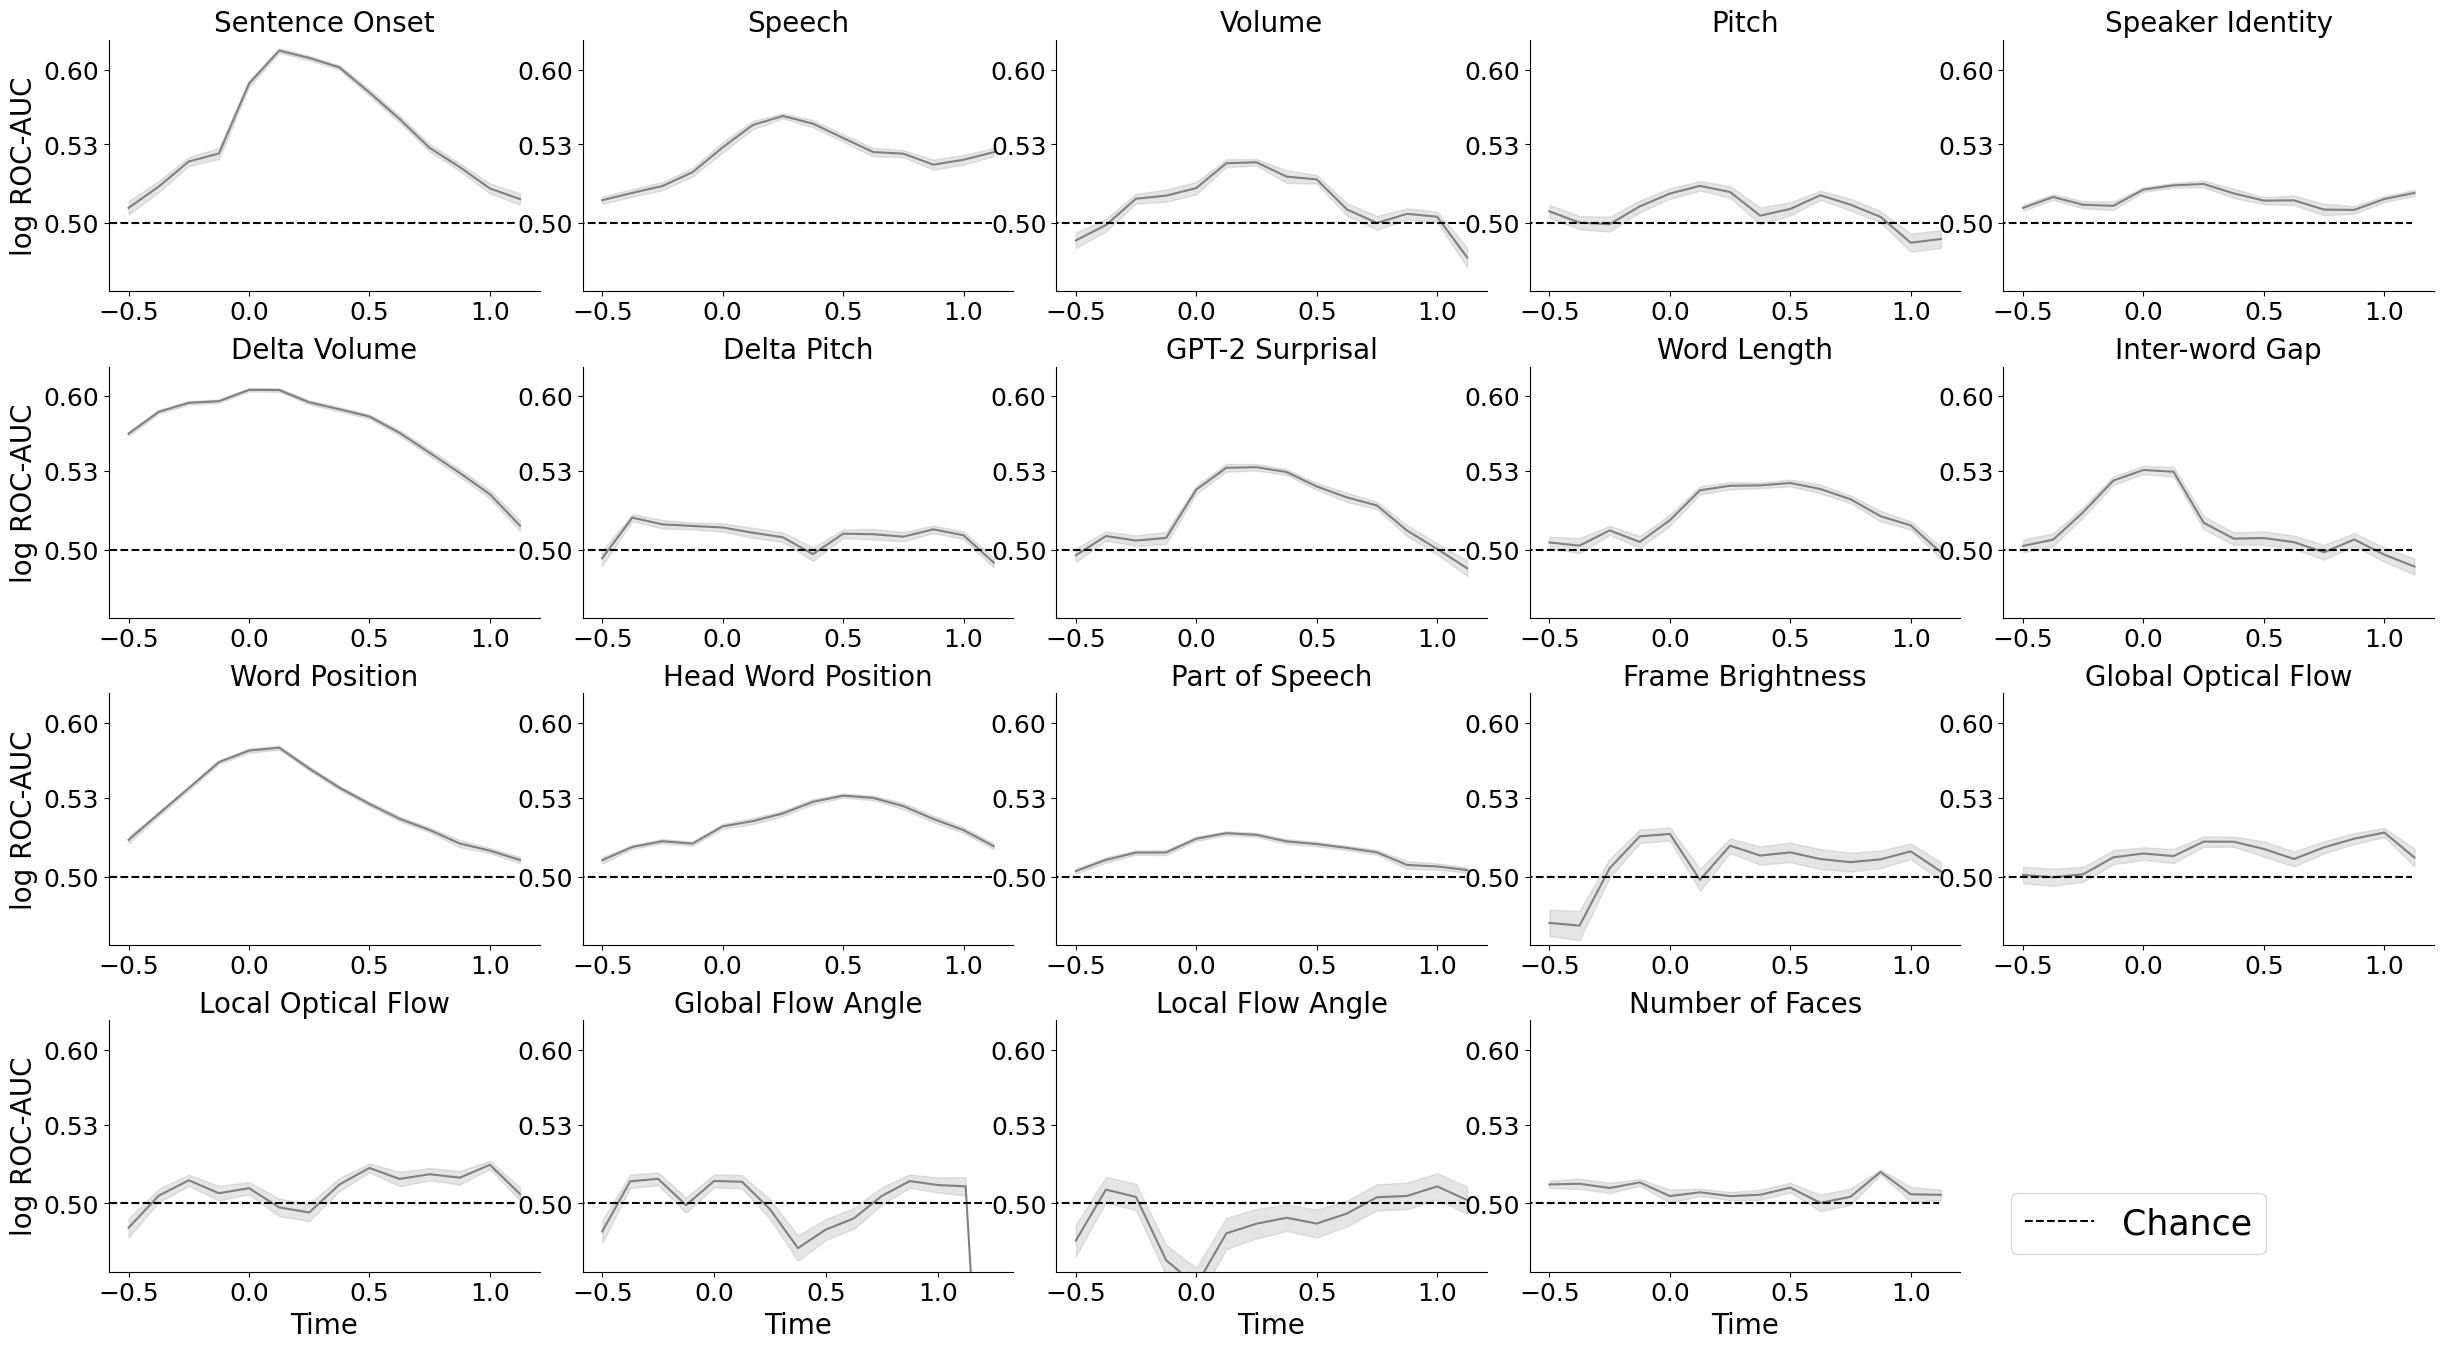

In [525]:
fig = plt.figure(figsize=(30, 16))

outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.1, hspace=0.3)

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(num_cols):
        # i,j = 0,2 #TODO
        # Index in outer grid
        outer_idx = i * num_cols + j

        if i*num_cols+j >= 19:
            
            continue

        ax = fig.add_subplot(outer[outer_idx])
        task = task_order[i*num_cols+j]

        task_df = results_df[results_df.task==task].groupby("ID").mean(["avg_test"])
#         good_elecs = task_df[task_df.avg_test>0.5].index   
        
        good_elecs = results_df[results_df.task==task].groupby("ID").mean(["avg_test"]).sort_values(by="avg_test").dropna()[-100:].index  
        time_df = results_df[(results_df.task==task) & (results_df.ID.isin(good_elecs))]
        # time_df.loc[:,'avg_test'] = [(100*x) for x in time_df['avg_test']]

        upper = 0.68
        lower = 0.48
        epsilon = 1e-4
        scale = lambda x: (np.log(max((x - lower), epsilon)))
        # scale = lambda x: (x - lower)
        # scale = lambda x: x
        time_df.loc[:,'avg_test'] = time_df['avg_test'].apply(scale)
        
#         time_df = results_df[(results_df.task==task)]

        # sns.set(style="whitegrid")

        # Create lineplot
        g = sns.lineplot(data=time_df, x="time_bin", y="avg_test", color="grey", errorbar="se")
        # plt.axis("off")  # disables the entire axis (spines, ticks, labels, etc.)
        plt.grid(False)  # ensures grid lines are also off
        ax.set_title(task_name_mapping[task], fontsize=20)
        sns.despine() 
        # plt.yscale('log')
        plt.ylim(scale(0.489), scale(0.65))
        if j==0:
            ax.set_ylabel("log ROC-AUC", fontsize=20)
        else:
            ax.set_ylabel("", fontsize=20)

        if i==num_rows-1:
            ax.set_xlabel("Time", fontsize=20)
        else:
            ax.set_xlabel("", fontsize=20)

        ax.tick_params(axis='both', which='major', labelsize=18)
        # ax.tick_params(axis='both', which='minor', labelsize=8)
        # plt.ylim(scale(1),scale(upper-lower))
        # for axes in g.axes:
        # ax.set_ylabel("ROC-AUC")
        #plt.ticklabel_format(axis='y', style='plain')             # <---- error
        ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{inverse_scale(val)}"))

        ax.set_yticks([scale(x) for x in [0.5, 0.53, 0.6]])

        ax.set_yticklabels(["0.50", "0.53", "0.60"])

        plt.axhline(y=scale(0.5), xmin=-0.5, xmax=0.95, color="black", ls="--", label="Chance")

        if i*num_cols+j >= 18:
            plt.legend(loc="lower right", fontsize=25, bbox_to_anchor=(1.75, 0))
# from matplotlib.ticker import ScalarFormatter
# plt.gca().yaxis.set_major_formatter(ScalarFormatter()) 
# plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
        
        # from matplotlib.ticker import ScalarFormatter
        # plt.gca().yaxis.set_major_formatter(ScalarFormatter()) 
        # plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
        # if 
        # break
    # break
plt.tight_layout()

In [505]:
scale(0.5), inverse_scale(-3.912023005428145)

(np.float64(-3.912023005428145), np.float64(0.5))

scale(0.56), scale(0.8)

In [499]:
upper = 0.7
lower = 0.48
time_df.loc[:,'avg_test'] = np.log(100*(time_df['avg_test'] - lower)/(upper - lower))

/storage/czw/anaconda3/envs/nilearn/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [500]:
scale(0.7)

np.float64(-1.5141277326297757)

In [501]:
time_df.loc[:,'avg_test'] = time_df['avg_test']

In [502]:
time_df['avg_test'].

SyntaxError: invalid syntax (2785005349.py, line 1)

# Make superimposed

In [526]:
time_df

,subject,trial,ID,electrode,avg_test,time_bin,task
12670,1,2,F3dIe4-sub_1,F3dIe4,-3.823776,-0.500,face_num
12671,1,2,F3dIe4-sub_1,F3dIe4,-3.285949,-0.375,face_num
12672,1,2,F3dIe4-sub_1,F3dIe4,-3.448990,-0.250,face_num
12673,1,2,F3dIe4-sub_1,F3dIe4,-3.533150,-0.125,face_num
12674,1,2,F3dIe4-sub_1,F3dIe4,-3.659375,0.000,face_num
...,...,...,...,...,...,...,...
838403,2,1,LT2aA2-sub_2,LT2aA2,-3.762204,0.625,face_num
838404,2,1,LT2aA2-sub_2,LT2aA2,-4.045036,0.750,face_num
838405,2,1,LT2aA2-sub_2,LT2aA2,-4.024604,0.875,face_num
838406,2,1,LT2aA2-sub_2,LT2aA2,-3.981647,1.000,face_num


In [616]:
time_df

,subject,trial,ID,electrode,avg_test,time_bin,task
12670,1,2,F3dIe4-sub_1,F3dIe4,0.501845,-0.500,face_num
12671,1,2,F3dIe4-sub_1,F3dIe4,0.517405,-0.375,face_num
12672,1,2,F3dIe4-sub_1,F3dIe4,0.511778,-0.250,face_num
12673,1,2,F3dIe4-sub_1,F3dIe4,0.509213,-0.125,face_num
12674,1,2,F3dIe4-sub_1,F3dIe4,0.505749,0.000,face_num
...,...,...,...,...,...,...,...
838403,2,1,LT2aA2-sub_2,LT2aA2,0.503232,0.625,face_num
838404,2,1,LT2aA2-sub_2,LT2aA2,0.497509,0.750,face_num
838405,2,1,LT2aA2-sub_2,LT2aA2,0.497870,0.875,face_num
838406,2,1,LT2aA2-sub_2,LT2aA2,0.498655,1.000,face_num


/tmp/ipykernel_2105105/1965126586.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 3000x1600 with 0 Axes>

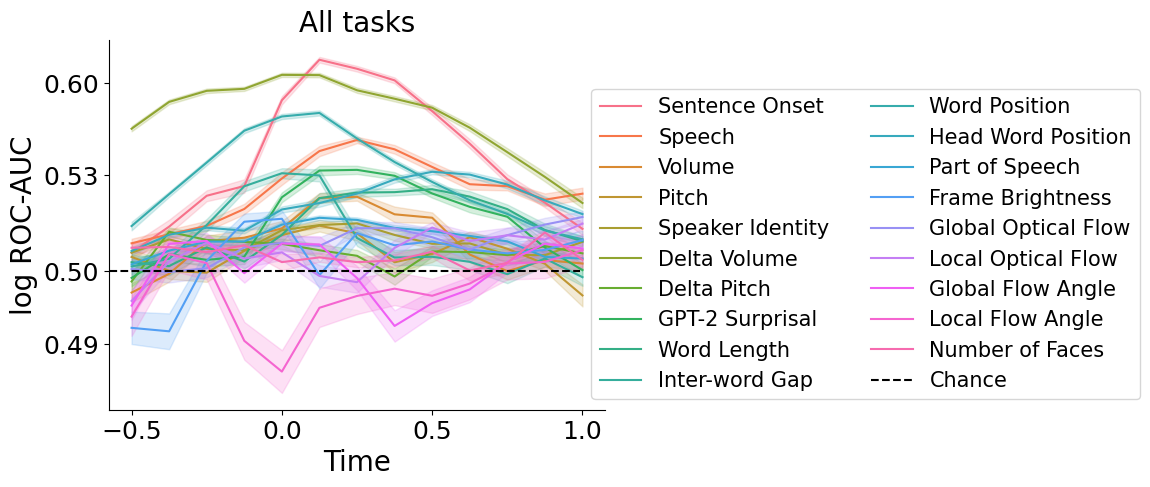

In [623]:
fig = plt.figure(figsize=(30, 16))

fig, ax = plt.subplots()

all_time_dfs = []
for task in task_order:
    good_elecs = results_df[results_df.task==task].groupby("ID").mean(["avg_test"]).sort_values(by="avg_test").dropna()[-100:].index  
    time_df = results_df[(results_df.task==task) & (results_df.ID.isin(good_elecs))]
    time_df = time_df[time_df.time_bin <= 1.0]
    time_df.loc[:,'avg_test'] = time_df['avg_test'].apply(scale) #TODO
    all_time_dfs.append(time_df)
    
all_time_df = pd.concat(all_time_dfs)

upper = 0.68
lower = 0.48
epsilon = 1e-4
scale = lambda x: (np.log(max((x - lower), epsilon)))

all_time_df.loc[:,'task'] = [task_name_mapping[x] for x in all_time_df['task']]
# Create lineplot
sns.lineplot(data=all_time_df, x="time_bin", y="avg_test", hue="task", errorbar="se", ax=ax)


plt.grid(False)  # ensures grid lines are also off
ax.set_title("All tasks", fontsize=20)
sns.despine() 
# plt.ylim(scale(0.489), scale(0.65)) #TODO

ax.set_ylabel("log ROC-AUC", fontsize=20)

ax.set_xlabel("Time", fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=18)

# ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{inverse_scale(val)}")) #TODO

ax.set_yticks([scale(x) for x in [0.49, 0.5, 0.53, 0.6]]) #TODO
 
ax.set_yticklabels(["0.49", "0.50", "0.53", "0.60"]) #TODO

plt.axhline(y=scale(0.5), xmin=-0.5, xmax=0.95, color="black", ls="--", label="Chance") #TODO

if i*num_cols+j >= 18:
    plt.legend(loc="lower right", fontsize=15, bbox_to_anchor=(2.1, 0), ncol=2)

plt.tight_layout()

<Axes: xlabel='time_bin', ylabel='avg_test'>

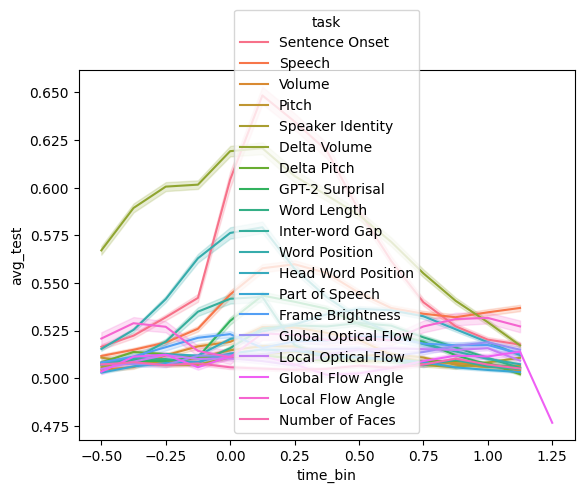

In [603]:
fig, ax = plt.subplots()

sns.lineplot(data=all_time_df, x="time_bin", y="avg_test", hue="task", errorbar="se", ax=ax)

# make timeline

In [ ]:
task_name_mapping = {
        'onset': 'Sentence Onset',
        'speech': 'Speech',
        'volume': 'Volume', 
        'pitch': 'Pitch',
        'speaker': 'Speaker Identity',
        'delta_volume': 'Delta Volume',
        'delta_pitch': 'Delta Pitch',
        'gpt2_surprisal': 'GPT-2 Surprisal',
        'word_length': 'Word Length',
        'word_gap': 'Inter-word Gap',
        'word_index': 'Word Position',
        'word_head_pos': 'Head Word Position',
        'word_part_speech': 'Part of Speech',
        'frame_brightness': 'Frame Brightness',
        'global_flow': 'Global Optical Flow',
        'local_flow': 'Local Optical Flow',
        'global_flow_angle': 'Global Flow Angle',
        'local_flow_angle': 'Local Flow Angle',
        'face_num': 'Number of Faces',
    }

In [387]:
records = []
for task in task_order:
    good_elecs = results_df[results_df.task==task].groupby("ID").mean(["avg_test"]).sort_values(by="avg_test").dropna()[-100:].index  
    time_df = results_df[(results_df.task==task) & (results_df.ID.isin(good_elecs))]
    
    time_df = time_df.groupby("time_bin").mean("avg_test")
    time_df['time_bin'] = time_df.index
    # time_df
    time = time_df.sort_values(by="avg_test").reset_index(drop=True).iloc[-1]["time_bin"]
    records.append({"time_bin": time,
                    "task": task_name_mapping[task]})
argmax_time = pd.DataFrame.from_records(records)
# time_df

In [388]:
argmax_time = argmax_time.sort_values(by="time_bin")
argmax_time.reset_index(drop=True)

,time_bin,task
0,-0.375,Delta Pitch
1,0.000,Frame Brightness
2,0.125,Pitch
3,0.125,Sentence Onset
4,0.125,GPT-2 Surprisal
5,0.125,Delta Volume
6,0.125,Inter-word Gap
7,0.125,Volume
8,0.125,Part of Speech
9,0.125,Word Position


In [389]:
dates = list(argmax_time.time_bin)
releases = list(argmax_time.task)


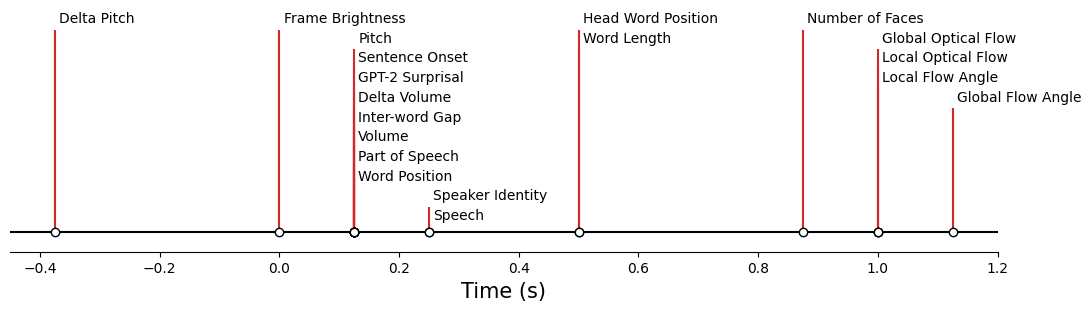

In [400]:
# Choose some nice levels: alternate meso releases between top and bottom, and
# progressively shorten the stems for micro releases.
levels = []
for i in range(len(releases)):
    release = releases[i]
    date = dates[i]
    h = 1 + 0.8 * (9)
    # print(date)
    if i>0 and (date-dates[i-1])<=0.125:
    # left_nbr = 
        # print("trig")
        h = levels[i-1] - 0.8
    # else:
        # print("no trig")
    level = h 
    levels.append(level)


def is_feature(release):
    """Return whether a version (split into components) is a feature release."""
    return release[-1] == '0'


# The figure and the axes.
fig, ax = plt.subplots(figsize=(10.8, 3), layout="constrained")
# ax.set(title="Location of decodability peak")

# The vertical stems.
ax.vlines(dates, 0, levels,
          color=[("tab:red", 1) for release in releases])
# The baseline.
ax.axhline(0, c="black")
# The markers on the baseline.
micro_dates = [date for date, release in zip(dates, releases)
               if not is_feature(release)]
ax.plot(micro_dates, np.zeros_like(micro_dates), "ko", mfc="white")

# Annotate the lines.
for date, level, release in zip(dates, levels, releases):
    version_str = release
    ax.annotate(version_str, xy=(date, level),
                xytext=(3, np.sign(level)*3), textcoords="offset points",
                verticalalignment="bottom",
                weight="bold" if is_feature(release) else "normal",
                bbox=dict(boxstyle='square', pad=0, lw=0, fc=(1, 1, 1, 0.7)))

# ax.xaxis.set(major_locator=mdates.YearLocator(),
             # major_formatter=mdates.DateFormatter("%Y"))

# Remove the y-axis and some spines.
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)
ax.set_xlabel("Time (s)", fontsize=15)
ax.margins(y=0.1)
plt.show()

# get stats

In [563]:
results_df

,subject,trial,ID,electrode,avg_test,time_bin,task
0,9,0,T1b1-sub_9,T1b1,0.481273,-0.500,speech
1,9,0,T1b1-sub_9,T1b1,0.477107,-0.375,speech
2,9,0,T1b1-sub_9,T1b1,0.494581,-0.250,speech
3,9,0,T1b1-sub_9,T1b1,0.479030,-0.125,speech
4,9,0,T1b1-sub_9,T1b1,0.481981,0.000,speech
...,...,...,...,...,...,...,...
1004639,3,0,O1bId16-sub_3,O1bId16,0.521015,0.625,gpt2_surprisal
1004640,3,0,O1bId16-sub_3,O1bId16,0.506986,0.750,gpt2_surprisal
1004641,3,0,O1bId16-sub_3,O1bId16,0.490335,0.875,gpt2_surprisal
1004642,3,0,O1bId16-sub_3,O1bId16,0.504640,1.000,gpt2_surprisal


In [564]:
task="onset"
good_elecs = results_df[results_df.task==task].groupby("ID").mean(["avg_test"]).sort_values(by="avg_test").dropna()[-100:].index  
time_df = results_df[(results_df.task==task) & (results_df.ID.isin(good_elecs))]

In [582]:
f"{time_df.groupby('time_bin').mean('avg_test').loc[-0.250][0]:.02}", f"{time_df.groupby('time_bin')['avg_test'].sem()[-0.25]:.02}"

/tmp/ipykernel_2105105/2654844275.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"{time_df.groupby('time_bin').mean('avg_test').loc[-0.250][0]:.02}", f"{time_df.groupby('time_bin')['avg_test'].sem()[-0.25]:.02}"


('0.53', '0.0015')